In [1]:
pip install keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.5/573.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 23.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import matplotlib.pyplot as plt
import os

D0905 22:49:42.545729852      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0905 22:49:42.545765789      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0905 22:49:42.545769331      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0905 22:49:42.545772262      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0905 22:49:42.545774659      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0905 22:49:42.545777243      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0905 22:49:42.545779621      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0905 22:49:42.

Using TensorFlow backend


# Accelerator

In [3]:
 try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    # instantiate a distribution strategy
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not activated")
    strategy = tf.distribute.MirroredStrategy() # Works on CPU, single GPU and multiple GPUs in a single VM.
    
print("replicas:", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# Load the Contradictory, My Dear Watson dataset
Let's have a look at all the data files

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data

In [4]:
df_train = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [5]:
VALIDATION_SPLIT = 0.3
TRAIN_SIZE = int(df_train.shape[0]*(1-VALIDATION_SPLIT))
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

Here's a utility function that splits the example into an `(x, y)` tuple that is suitable for `model.fit()`.

By default, `keras_nlp.models.BertClassifier` will tokenize and pack together raw strings using a `"[SEP]"` token during training.

Therefore, this label splitting is all the data preparation that we need to perform.

In [6]:
def split_labels(x, y):
    return (x[0], x[1]), y


training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            df_train[['premise','hypothesis']].values,
            keras.utils.to_categorical(df_train['label'], num_classes=3)
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

train_preprocessed = train_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

# Load a BERT model from Keras NLP - Train the model

In [7]:
# Load a BERT model.

with strategy.scope():
    classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", num_classes=3)

    # in distributed training, the recommendation is to scale batch size and learning rate with the numer of workers.
    classifier.compile(optimizer=keras.optimizers.Adam(1e-5*strategy.num_replicas_in_sync),
                       loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
    classifier.summary()

711647480/711647480 [==============================] - 25s 0us/step


Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                             119,547 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 768),   │     177,853,440 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout (Dropout)                             │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 3)                              │           2,307 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 177,855,747 (678.47 MB)

 Trainable params: 177,855,747 (678.47 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model - Fine-tuning BERT

In [8]:
EPOCHS=6
history = classifier.fit(train_preprocessed,
                         epochs=EPOCHS,
                         validation_data=val_preprocessed)

Epoch 1/6


2024-09-05 22:51:31.333434: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-09-05 22:51:32.187169: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


66/66 [==============================] - ETA: 0s - loss: 0.9826 - accuracy: 0.5075

2024-09-05 22:52:54.049952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-09-05 22:52:54.304986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


66/66 [==============================] - 122s 660ms/step - loss: 0.9826 - accuracy: 0.5075 - val_loss: 0.8651 - val_accuracy: 0.6214
Epoch 2/6
66/66 [==============================] - 33s 491ms/step - loss: 0.7678 - accuracy: 0.6674 - val_loss: 0.8479 - val_accuracy: 0.6306
Epoch 3/6
66/66 [==============================] - 32s 492ms/step - loss: 0.5788 - accuracy: 0.7617 - val_loss: 0.9884 - val_accuracy: 0.6320
Epoch 4/6
66/66 [==============================] - 33s 503ms/step - loss: 0.4360 - accuracy: 0.8320 - val_loss: 1.0820 - val_accuracy: 0.6328
Epoch 5/6
66/66 [==============================] - 32s 494ms/step - loss: 0.3699 - accuracy: 0.8641 - val_loss: 1.2569 - val_accuracy: 0.6027
Epoch 6/6
66/66 [==============================] - 32s 490ms/step - loss: 0.2412 - accuracy: 0.9128 - val_loss: 1.4975 - val_accuracy: 0.6127


In [9]:
history_df = pd.DataFrame(history.history)

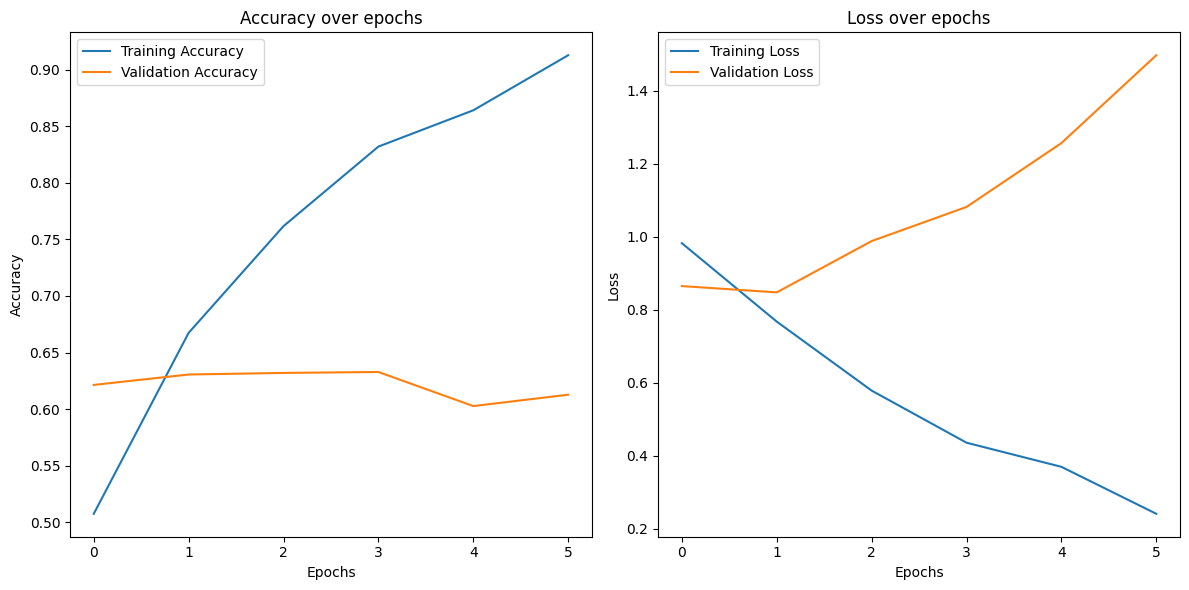

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()